#### Initial Module importing

In [2]:
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation
from keras import losses
from keras.optimizers import Adam, Adagrad, SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import utils
import keras
from keras.layers import BatchNormalization

from tensorflow.keras.datasets import cifar10, cifar100

import numpy as np
import matplotlib.pyplot as plt
import os 

2023-04-11 01:15:32.449184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Random Seed Setting

In [3]:
import random
import tensorflow as tf
import os


def set_seed(seed=42):
    '''
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

#### Cifar 10 Data Loading

In [4]:
(cifar10_X_train, cifar10_y_train),(cifar10_X_test, cifar10_y_test)=cifar10.load_data()

print('input_X_train shape: ', cifar10_X_train.shape)
print(cifar10_X_train.shape[0], 'train samples')
print(cifar10_X_test.shape[0], 'test samples')

input_X_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
cifar10_N_CLASSES = len(np.unique(cifar10_y_train))
print(cifar10_N_CLASSES)

10


In [6]:
# output data one-hot encoding 
cifar10_y_train=utils.to_categorical(cifar10_y_train, cifar10_N_CLASSES)
cifar10_y_test=utils.to_categorical(cifar10_y_test, cifar10_N_CLASSES)

# To normalize the value in between 0 and 1 (there are 255 kinds)
cifar10_X_train=cifar10_X_train.astype('float32')
cifar10_X_test=cifar10_X_test.astype('float32')

cifar10_X_train /=255
cifar10_X_test /=255

#### Cifar 100 Loading

In [4]:
(cifar100_X_train, cifar100_y_train),(cifar100_X_test, cifar100_y_test)=cifar100.load_data()

print('input_X_train shape: ', cifar100_X_train.shape)
print(cifar100_X_train.shape[0], 'train samples')
print(cifar100_X_test.shape[0], 'test samples')

input_X_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [98]:
cifar100_N_CLASSES=len(np.unique(cifar100_y_train))
print(cifar100_N_CLASSES)

100


In [ ]:
# output data one-hot encoding 
cifar100_y_train=utils.to_categorical(cifar100_y_train, cifar100_N_CLASSES)
cifar100_y_test=utils.to_categorical(cifar100_y_test, cifar100_N_CLASSES)

# To normalize the value in between 0 and 1 (there are 255 kinds)
cifar100_X_train=cifar100_X_train.astype('float32')
cifar100_X_test=cifar100_X_test.astype('float32')

cifar100_X_train /=255
cifar100_X_test /=255

### Model training - Random Search

In [7]:
params = {
     'learning_rate': (0.1, 0.01,1,0.001 ),
     'epochs': [20,30,40,50],
     'batch_size':[128, 256, 512],
     'dropout': (0, 0.5, 0.8),
     'optimizer': ["Adam","RMSprop","sgd"],
     'decay':(1e-6,1e-4,1e-2),
     'momentum':(0.9,0.5,0.2),
     'l1': (0.01,0.001,0.0001),
     'l2': (0.01,0.001,0.0001),
     'No_of_CONV_and_Maxpool_layers':[2,3],
     'No_of_Dense_Layers': [2,3,4,5],
     'No_of_Units_in_dense_layers':[128,64,256,512],
     'Conv2d_filters':[32,64,128,256],
     'validation_split':[0.1, 0.2],
     'No_of_batch_norm':[True, False]
    }

IMG_CHANNELS = 3
IMAGE_SIZE = cifar10_X_train.shape[1]


In [8]:
def Randomized_Model(learning_rate=0.001, dropout=0.2, optimizer="Adam", decay=0.0,
                      activation="relu", momentum=0.0, l1=0.0, l2=0.0, No_of_batch_norm=False,
                      No_of_CONV_and_Maxpool_layers=3, No_of_Dense_Layers=3, No_of_Units_in_dense_layers=24,
                      Conv2d_filters=60, batch_size=32, epochs=10, validation_split=0.1):

    #model sequential
    model = Sequential()
    
    # input layer
    model.add(Conv2D(Conv2d_filters, (3,3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMG_CHANNELS)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
    
    # Hidden Layer
    for i in range(0, No_of_CONV_and_Maxpool_layers):
        model.add(Conv2D(Conv2d_filters, (3, 3), padding="same"))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(dropout))
        if No_of_batch_norm == True:
            BatchNormalization()
        else:
            pass
        
    
    # Output Layer
    model.add(Flatten())  
    for i in range (0,No_of_Dense_Layers):
        model.add(Dense(units=No_of_Units_in_dense_layers,activation=activation, kernel_regularizer=regularizers.l2(l2),
                  activity_regularizer=regularizers.l1(l1)))
        model.add(Dropout(dropout))
    model.add(Dense(units=512,activation=activation))     
    model.add(Dense(units=cifar10_N_CLASSES, activation='softmax'))
        
    if optimizer == "Adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)
    elif optimizer == "RMSprop":
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate,momentum=momentum,decay=decay)
    elif optimizer == "sgd":
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #model.summary()

    return model


In [9]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer

# model class to use in the scikit random search CV 
model = KerasClassifier(build_fn=Randomized_Model, epochs=10, batch_size=20, verbose=1)
grid = RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=params, 
                          verbose=20,  n_iter=10, n_jobs=1)

grid_result = grid.fit(cifar10_X_train, cifar10_y_train)

/var/folders/0x/n51_7s_n09dfndljqk4rv2zr0000gn/T/ipykernel_81995/3991797947.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=Randomized_Model, epochs=10, batch_size=20, verbose=1)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START Conv2d_filters=256, No_of_CONV_and_Maxpool_layers=3, No_of_Dense_Layers=2, No_of_Units_in_dense_layers=256, No_of_batch_norm=False, batch_size=512, decay=0.01, dropout=0.8, epochs=30, l1=0.01, l2=0.001, learning_rate=0.01, momentum=0.2, optimizer=Adam, validation_split=0.1
Epoch 1/30
59/59 [==============================] - 554s 9s/step - loss: 3.0144 - accuracy: 0.0988 - val_loss: 2.5558 - val_accuracy: 0.1056
Epoch 2/30
59/59 [==============================] - 583s 10s/step - loss: 2.4383 - accuracy: 0.1023 - val_loss: 2.3703 - val_accuracy: 0.1056
Epoch 3/30
59/59 [==============================] - 576s 10s/step - loss: 2.3471 - accuracy: 0.0994 - val_loss: 2.3311 - val_accuracy: 0.1056
Epoch 4/30
59/59 [==============================] - 587s 10s/step - loss: 2.3235 - accuracy: 0.0994 - val_loss: 2.3178 - val_accuracy: 0.1056
Epoch 5/30
59/59 [==============================] - 578s 10s/step - loss: 2.3

In [10]:
model = Randomized_Model()
model.summary()
last_layer_shape = model.layers[-1].output_shape
print("Shape of last layer:", last_layer_shape)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 32, 32, 60)        1680      
                                                                 
 activation_102 (Activation)  (None, 32, 32, 60)       0         
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 16, 16, 60)       0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 16, 16, 60)        32460     
                                                                 
 activation_103 (Activation)  (None, 16, 16, 60)       0         
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 8, 8, 60)         0         
 ng2D)                                               

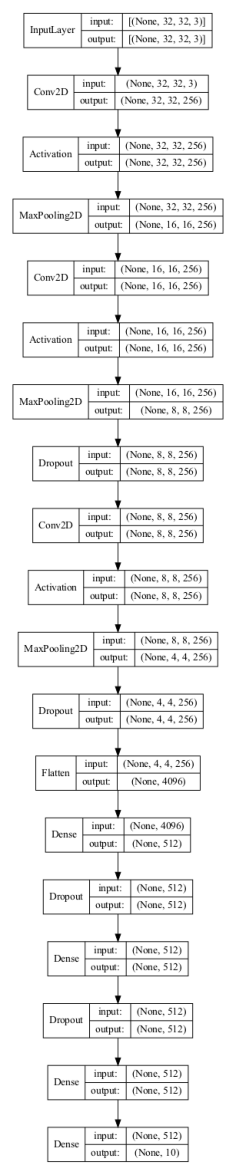

In [94]:
from tensorflow.keras.utils import plot_model
# Plot the model as an image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, dpi=70)

# Display the plot
img = plt.imread('model.png')
plt.figure(figsize=(10,15))
plt.imshow(img)
plt.axis('off')
plt.show()

In [31]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.739100 using {'validation_split': 0.2, 'optimizer': 'Adam', 'momentum': 0.9, 'learning_rate': 0.001, 'l2': 0.0001, 'l1': 0.0001, 'epochs': 20, 'dropout': 0.5, 'decay': 1e-06, 'batch_size': 256, 'No_of_batch_norm': False, 'No_of_Units_in_dense_layers': 512, 'No_of_Dense_Layers': 2, 'No_of_CONV_and_Maxpool_layers': 2, 'Conv2d_filters': 256}


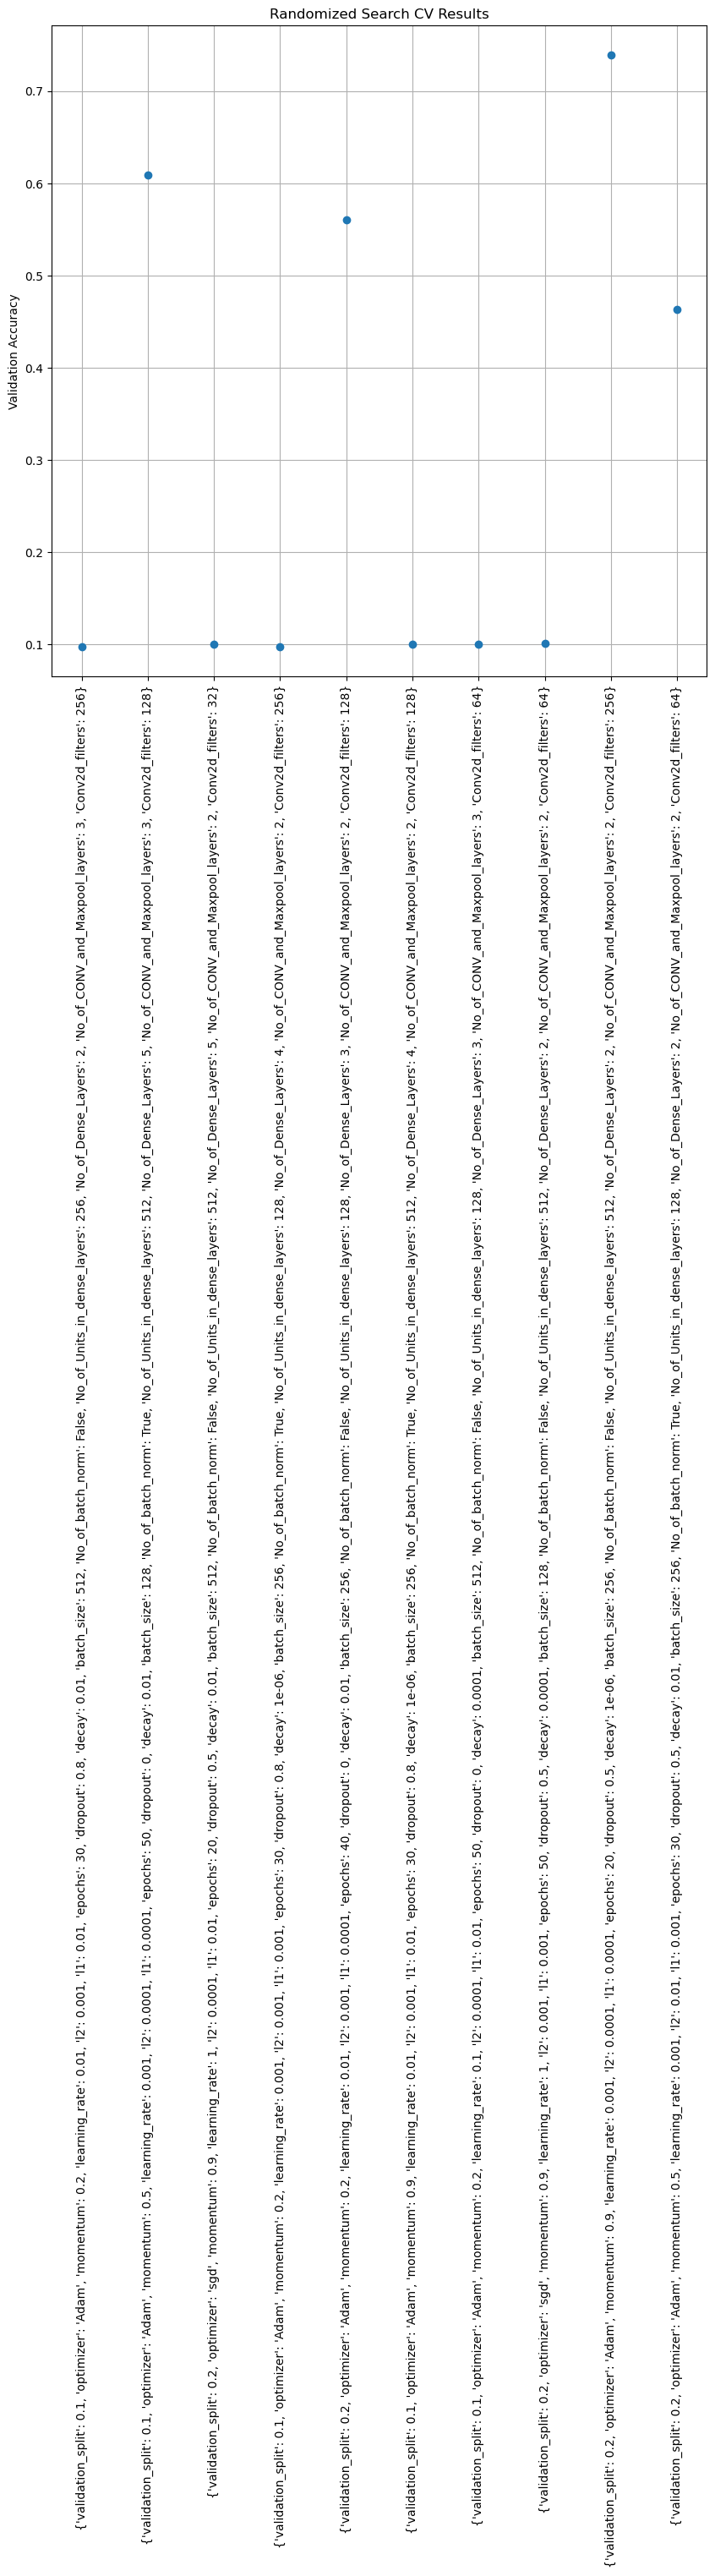

In [95]:
import matplotlib.pyplot as plt

results = grid_result.cv_results_

# Plotting validation accuracy for different hyperparameters
plt.figure(figsize=(10, 10))
plt.title("Randomized Search CV Results")
plt.xlabel("Hyperparameters")
plt.ylabel("Validation Accuracy")
plt.grid()

plt.plot(range(len(results["params"])), results["mean_test_score"], 'o')
plt.xticks(range(len(results["params"])), results["params"], rotation=90)
plt.show()


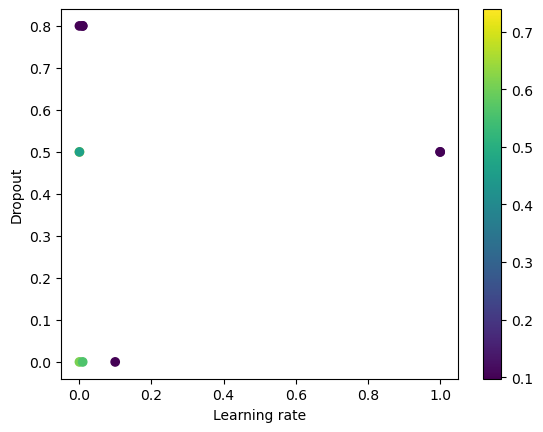

In [43]:
import matplotlib.pyplot as plt

# Get the results of the randomized search
results = grid_result.cv_results_

# Plot the validation accuracy for each combination of hyperparameters
plt.scatter(results['param_learning_rate'], results['param_dropout'], c=results['mean_test_score'])
plt.xlabel('Learning rate')
plt.ylabel('Dropout')
plt.colorbar()
plt.show()


Epoch 1/10
2250/2250 [==============================] - 2510s 1s/step - loss: 1.8797 - accuracy: 0.3232 - val_loss: 1.5854 - val_accuracy: 0.4522
Epoch 2/10
2250/2250 [==============================] - 2363s 1s/step - loss: 1.6296 - accuracy: 0.4491 - val_loss: 1.4408 - val_accuracy: 0.5514
Epoch 3/10
2250/2250 [==============================] - 2628s 1s/step - loss: 1.5555 - accuracy: 0.4903 - val_loss: 1.3185 - val_accuracy: 0.5888
Epoch 4/10
2250/2250 [==============================] - 2084s 926ms/step - loss: 1.5035 - accuracy: 0.5201 - val_loss: 1.3232 - val_accuracy: 0.6086
Epoch 5/10
2250/2250 [==============================] - 1690s 751ms/step - loss: 1.4768 - accuracy: 0.5417 - val_loss: 1.3116 - val_accuracy: 0.6212
Epoch 6/10
2250/2250 [==============================] - 1554s 691ms/step - loss: 1.4397 - accuracy: 0.5612 - val_loss: 1.3622 - val_accuracy: 0.5984
Epoch 7/10
2250/2250 [==============================] - 1380s 613ms/step - loss: 1.4297 - accuracy: 0.5728 - val_lo

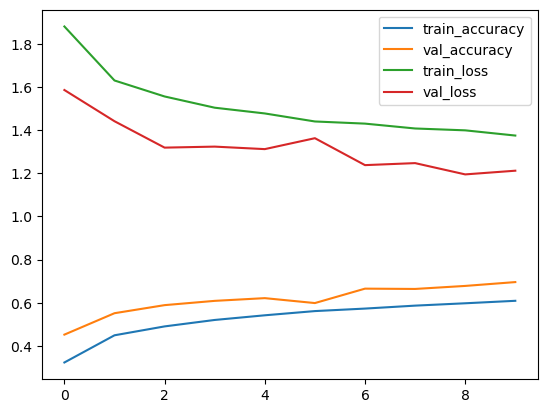

In [46]:
# Get the best model
best_model = grid_result.best_estimator_

# Train the model on the entire training set
history = best_model.fit(cifar10_X_train, cifar10_y_train, epochs=10, batch_size=20, validation_split=0.1)

# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


/var/folders/0x/n51_7s_n09dfndljqk4rv2zr0000gn/T/ipykernel_81995/2731524999.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = params_df.corr(method='pearson')


<AxesSubplot: >

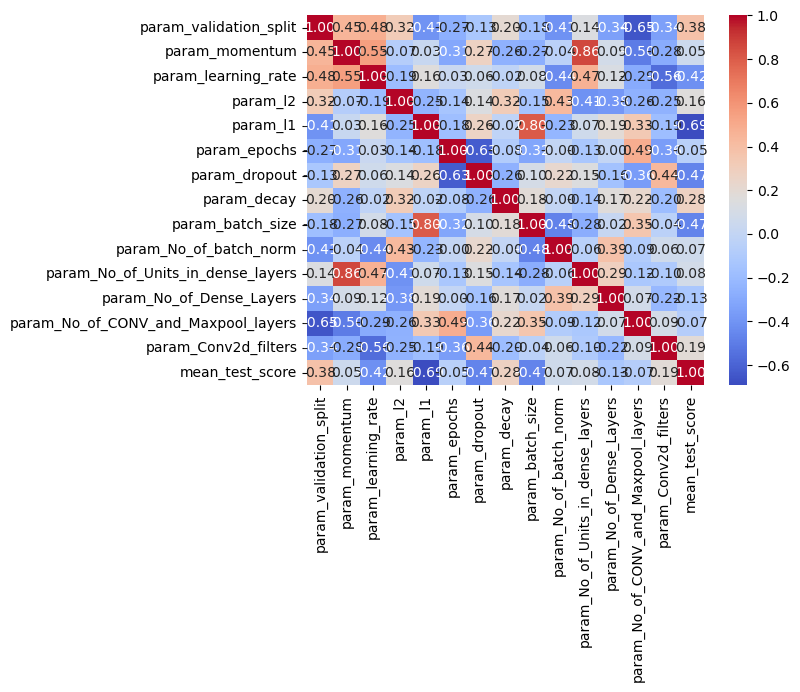

In [47]:
import seaborn as sns
import pandas as pd
import numpy as np

results_df = pd.DataFrame(grid_result.cv_results_)

# extract the columns with the hyperparameters and the mean test score
param_cols = [col for col in results_df.columns if col.startswith('param_')]
param_cols.append('mean_test_score')

# create a new DataFrame with the hyperparameters and the mean test score
params_df = results_df[param_cols].copy()

# convert the hyperparameter columns to the appropriate data type
for col in param_cols[:-1]:
    if isinstance(params_df[col][0], str):
        params_df[col] = params_df[col].astype('category')
    else:
        params_df[col] = params_df[col].astype(np.float32)

# compute the correlation between each hyperparameter and the mean test score
corr = params_df.corr(method='pearson')

# create the heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')


In [51]:
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_validation_split,param_optimizer,param_momentum,param_learning_rate,param_l2,param_l1,...,param_No_of_Dense_Layers,param_No_of_CONV_and_Maxpool_layers,param_Conv2d_filters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,13448.648287,805.713865,95.232046,19.363956,0.1,Adam,0.2,0.01,0.001,0.01,...,2,3,256,"{'validation_split': 0.1, 'optimizer': 'Adam',...",0.094738,0.098818,0.098164,0.097240,0.001789,9
1,7612.041990,762.968648,27.968477,1.782834,0.1,Adam,0.5,0.001,0.0001,0.0001,...,5,3,128,"{'validation_split': 0.1, 'optimizer': 'Adam',...",0.576768,0.624348,0.626485,0.609200,0.022949,2
2,463.395719,9.729050,5.533437,0.143461,0.2,sgd,0.9,1,0.0001,0.01,...,5,2,32,"{'validation_split': 0.2, 'optimizer': 'sgd', ...",0.100498,0.100618,0.099304,0.100140,0.000593,6
3,12994.965850,1241.990298,90.255509,9.849698,0.1,Adam,0.2,0.001,0.001,0.001,...,4,2,256,"{'validation_split': 0.1, 'optimizer': 'Adam',...",0.094738,0.098818,0.098164,0.097240,0.001789,9
4,4041.014415,6.775429,23.252653,0.324963,0.2,Adam,0.2,0.01,0.001,0.0001,...,3,2,128,"{'validation_split': 0.2, 'optimizer': 'Adam',...",0.604308,0.545329,0.532701,0.560779,0.031208,3


/var/folders/0x/n51_7s_n09dfndljqk4rv2zr0000gn/T/ipykernel_81995/105744630.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = params_df.corr(method='pearson')


<AxesSubplot: >

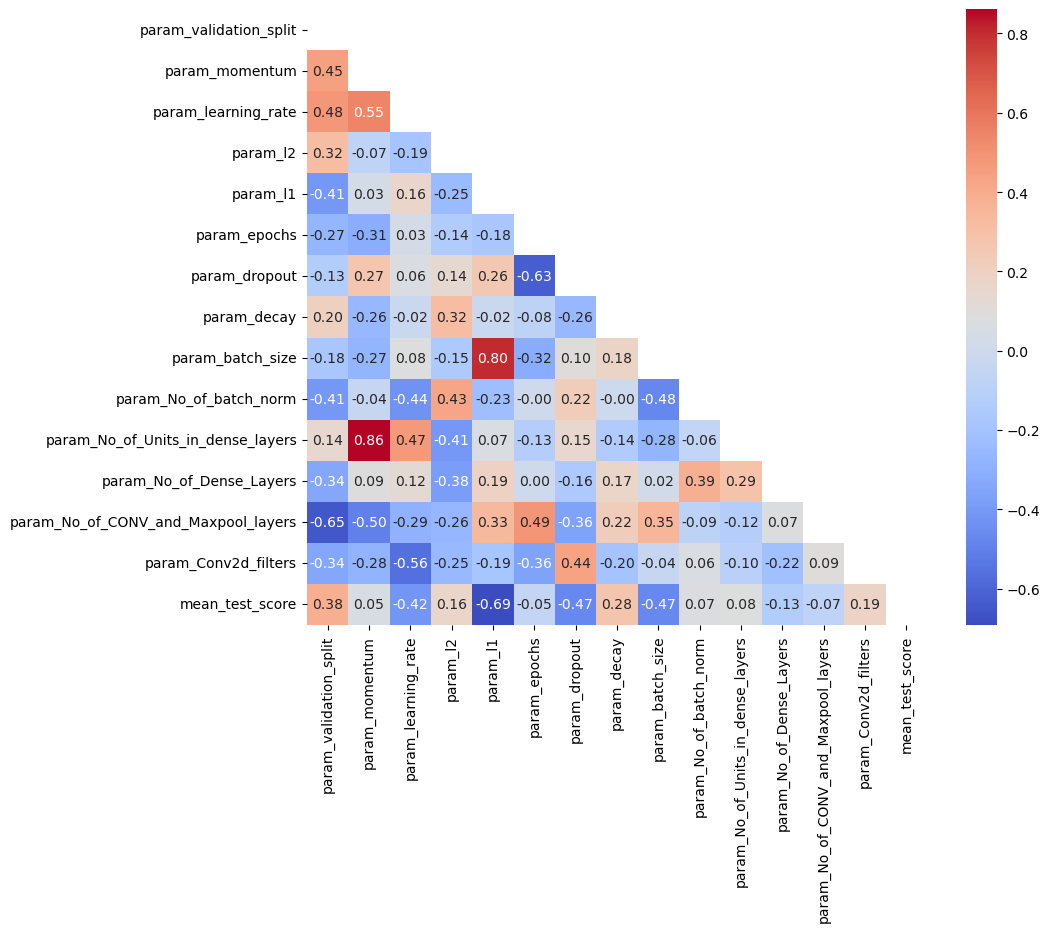

In [53]:
import seaborn as sns
import pandas as pd
import numpy as np

results_df = pd.DataFrame(grid_result.cv_results_)

# extract the columns with the hyperparameters and the mean test score
param_cols = [col for col in results_df.columns if col.startswith('param_')]
param_cols.append('mean_test_score')

# create a new DataFrame with the hyperparameters and the test score
params_df = results_df[param_cols].copy()

# convert the hyperparameter columns to the appropriate data type
for col in param_cols[:-1]:
    if isinstance(params_df[col][0], str):
        params_df[col] = params_df[col].astype('category')
    else:
        params_df[col] = params_df[col].astype(np.float32)

# compute the correlation between each hyperparameter and the test score
corr = params_df.corr(method='pearson')

# get the upper triangle of the correlation matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
# create the heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', mask=mask)


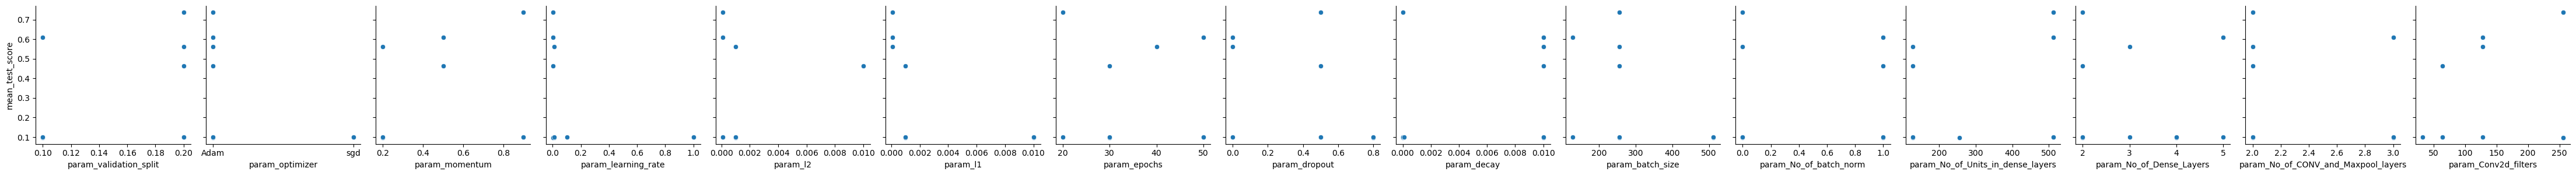

In [54]:
import seaborn as sns
import pandas as pd
import numpy as np

results_df = pd.DataFrame(grid_result.cv_results_)

# extract the columns with the hyperparameters and the test score
param_cols = [col for col in results_df.columns if col.startswith('param_')]
param_cols.append('mean_test_score')

# create a new DataFrame with the hyperparameters and the test score
params_df = results_df[param_cols].copy()

# convert the hyperparameter columns to the appropriate data type
for col in param_cols[:-1]:
    if isinstance(params_df[col][0], str):
        params_df[col] = params_df[col].astype('category')
    else:
        params_df[col] = params_df[col].astype(np.float32)

# create the scatter plot matrix
sns.pairplot(params_df, x_vars=param_cols[:-1], y_vars='mean_test_score', height=3)


In [60]:
import joblib
# Perform randomized search and save results

joblib.dump(grid_result.cv_results_, 'random_search_results.pkl')
# results = joblib.load('random_search_results.pkl')

['random_search_results.pkl']

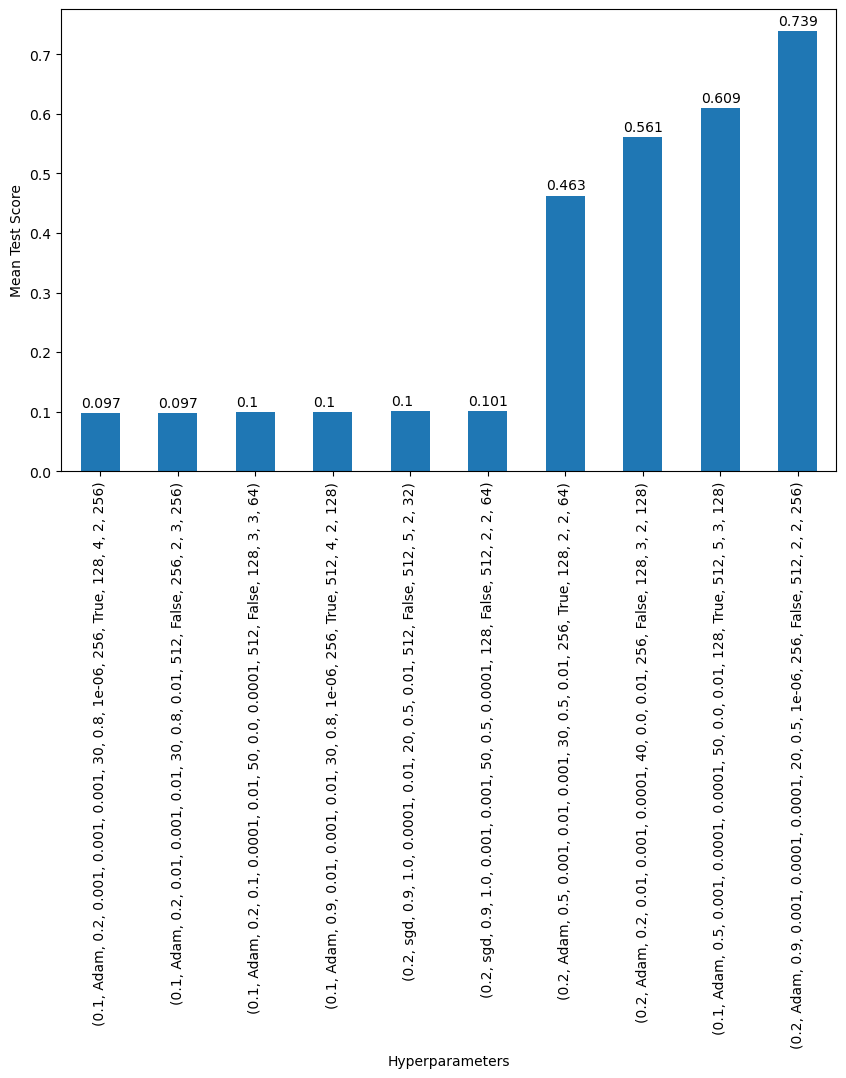

In [64]:
plt.figure(figsize=(10, 6))
results_df1 = pd.DataFrame(grid_result.cv_results_)
ax = results_df1.groupby(param_cols[:-1])['mean_test_score'].mean().sort_values().plot(kind='bar')
ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Mean Test Score')
for i, v in enumerate(results_df1.groupby(param_cols[:-1])['mean_test_score'].mean().sort_values()):
    ax.text(i - 0.25, v + 0.01, str(round(v, 3)), color='black', fontsize=10)
plt.show()


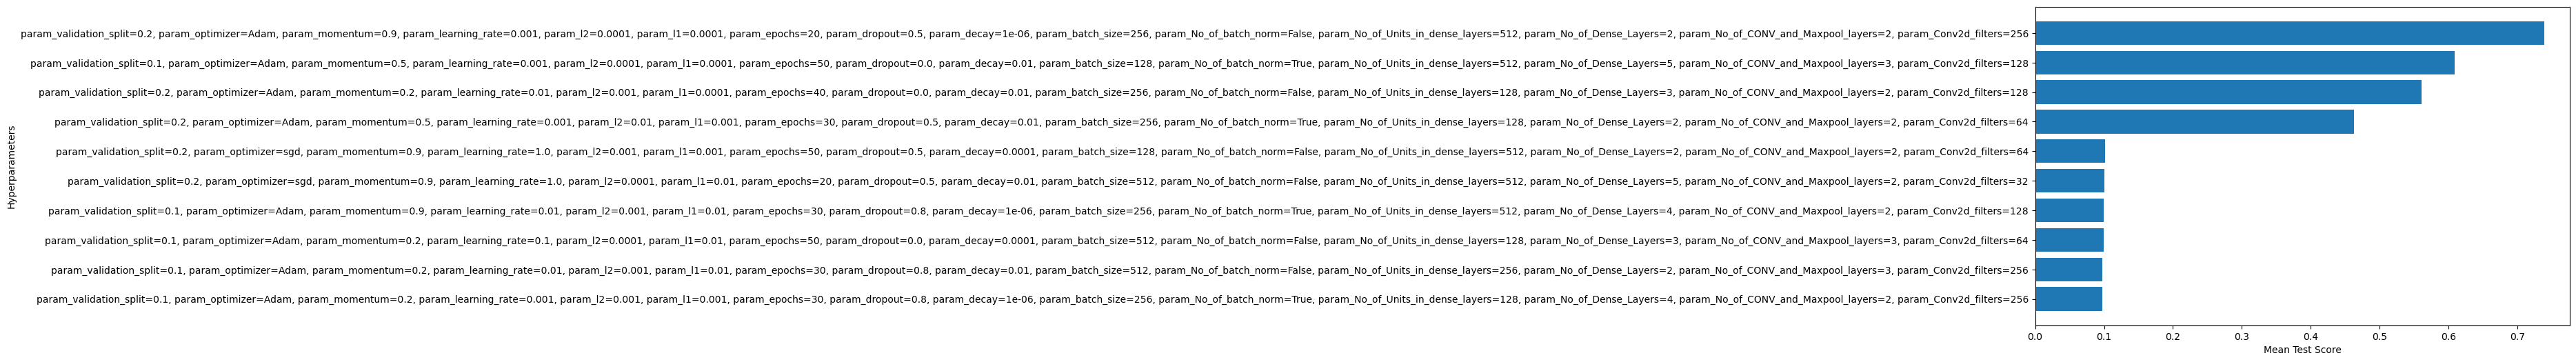

In [65]:
plt.figure(figsize=(10, 6))

results_df = pd.DataFrame(grid_result.cv_results_)
grouped_results = results_df.groupby(param_cols[:-1])['mean_test_score'].mean().sort_values().reset_index()

# Create a new column that contains a string representation of the hyperparameter values
grouped_results['Hyperparameters'] = grouped_results[param_cols[:-1]].apply(lambda x: ', '.join([f'{k}={v}' for k, v in x.items()]), axis=1)

# Plot the bar plot
plt.barh(y=grouped_results['Hyperparameters'], width=grouped_results['mean_test_score'])
plt.xlabel('Mean Test Score')
plt.ylabel('Hyperparameters')
plt.show()


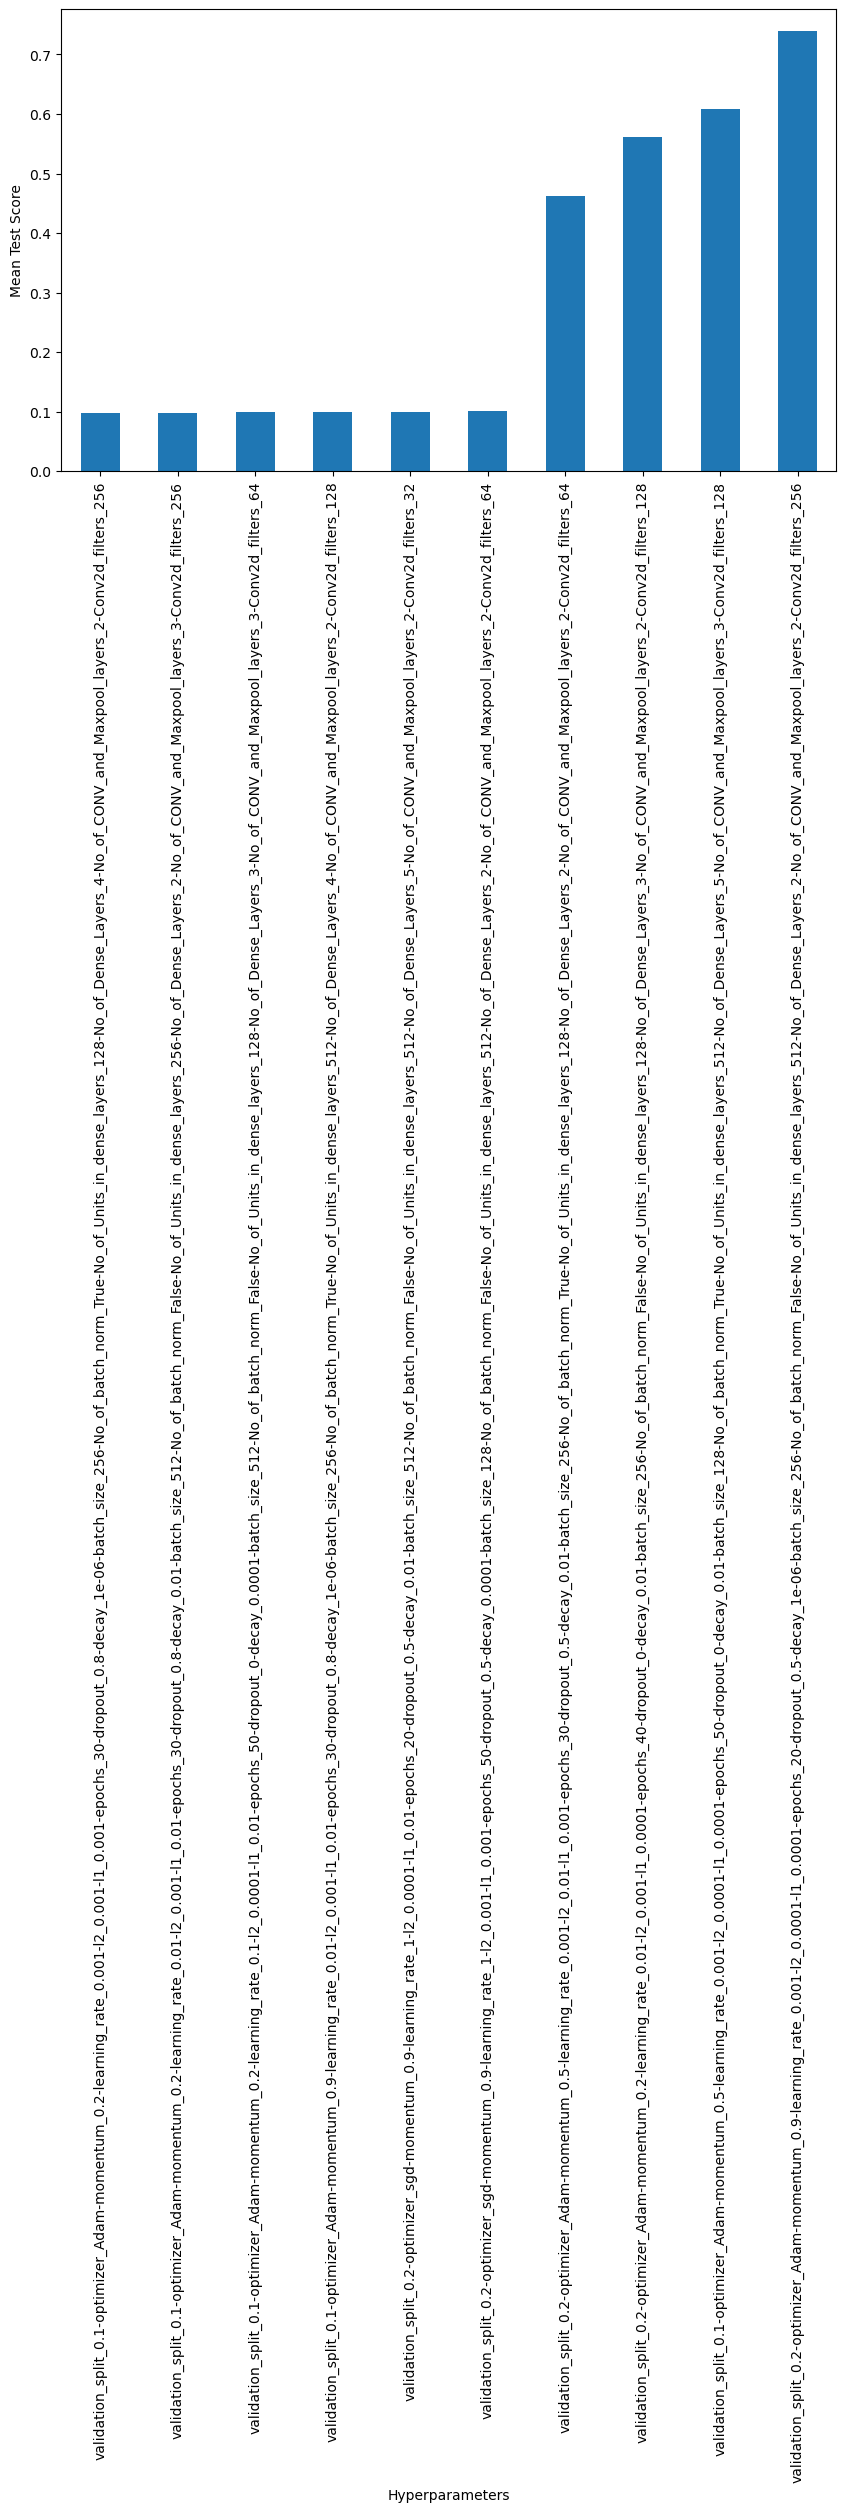

In [66]:
param_str = '-'.join([f'{key}_{val}' for key, val in params.items()])

# create a bar plot of the mean test score for each hyperparameter
plt.figure(figsize=(10, 6))

results_df1 = pd.DataFrame(grid_result.cv_results_)
results_df1['params_str'] = results_df1.params.apply(lambda x: '-'.join([f'{key}_{val}' for key, val in x.items()]))
results_df1.groupby('params_str')['mean_test_score'].mean().sort_values().plot(kind='bar')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Test Score')
plt.xticks(rotation=90)
plt.show()


0: param_validation_split_0.1 / param_optimizer_Adam / param_momentum_0.2 / param_learning_rate_0.01 / param_l2_0.001 / param_l1_0.01 / param_epochs_30 / param_dropout_0.8 / param_decay_0.01 / param_batch_size_512 / param_No_of_batch_norm_False / param_No_of_Units_in_dense_layers_256 / param_No_of_Dense_Layers_2 / param_No_of_CONV_and_Maxpool_layers_3 / param_Conv2d_filters_256
1: param_validation_split_0.1 / param_optimizer_Adam / param_momentum_0.5 / param_learning_rate_0.001 / param_l2_0.0001 / param_l1_0.0001 / param_epochs_50 / param_dropout_0 / param_decay_0.01 / param_batch_size_128 / param_No_of_batch_norm_True / param_No_of_Units_in_dense_layers_512 / param_No_of_Dense_Layers_5 / param_No_of_CONV_and_Maxpool_layers_3 / param_Conv2d_filters_128
2: param_validation_split_0.2 / param_optimizer_sgd / param_momentum_0.9 / param_learning_rate_1 / param_l2_0.0001 / param_l1_0.01 / param_epochs_20 / param_dropout_0.5 / param_decay_0.01 / param_batch_size_512 / param_No_of_batch_norm_F

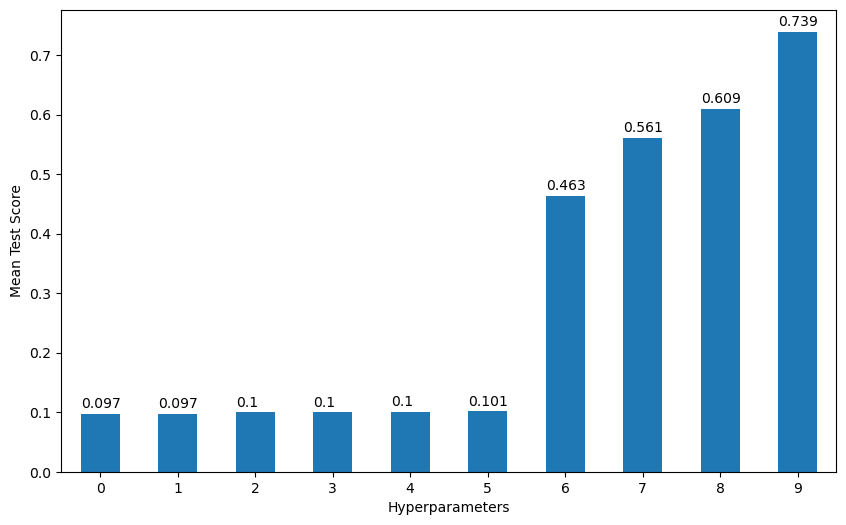

In [85]:
# create a dictionary mapping hyperparameter combinations to numbers
param_combinations = [tuple(param_dict.values()) for param_dict in grid_result.cv_results_['params']]

param_dict = {params: i for i, params in enumerate(param_combinations)}
param_cols = [col for col in results_df1.columns if col.startswith('param_')]

# create a bar plot of the mean test score for each hyperparameter
plt.figure(figsize=(10, 6))
ax = results_df1.groupby(param_cols[:-1])['mean_test_score'].mean().sort_values().plot(kind='bar')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Test Score')
plt.xticks(range(len(param_dict)), [f"{i}" for i in range(len(param_dict))], rotation=0)

# add the mean_test_score values to the top of each bar
for i, v in enumerate(results_df1.groupby(param_cols[:-1])['mean_test_score'].mean().sort_values()):
    ax.text(i - 0.25, v + 0.01, str(round(v, 3)), color='black', fontsize=10)
    
for i, params in enumerate(param_combinations):
    param_str = ' / '.join([f'{param_cols[j]}_{val}' for j, val in enumerate(params)])
    print(f"{i}: {param_str}")

In [89]:
from tabulate import tabulate

table = []
for i, params in enumerate(param_combinations):
    param_str = ' / '.join([f'{param_cols[j]}_{val}' for j, val in enumerate(params)])
    mean_test_score = results_df1.iloc[param_dict[params]]['mean_test_score']
    table.append([i, param_str, round(mean_test_score, 3)])

print(tabulate(table, headers=['Index', 'Hyperparameters', 'Mean Test Score']))


  Index  Hyperparameters                                                                                                                                                                                                                                                                                                                                                                                   Mean Test Score
-------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------------
      0  param_validation_split_0.1 / param_optimizer_Adam / param_momentum_0.2 / param_learning_rate_0.01 / param_l2_0.001 / param_l1_0.01 / param_epochs_30 / param_dropout_0.8 

In [105]:
import pandas as pd

results_df = pd.DataFrame(grid_result.cv_results_)

# extract the columns with the hyperparameters and the mean test score
param_cols = [col for col in results_df.columns if col.startswith('param_')]
param_cols.append('mean_test_score')

# print the results as a table
print(results_df[param_cols])

# save the results to a file
results_df[param_cols].to_csv('randomizedSearch_results.csv', index=False)


  param_validation_split param_optimizer param_momentum param_learning_rate  \
0                    0.1            Adam            0.2                0.01   
1                    0.1            Adam            0.5               0.001   
2                    0.2             sgd            0.9                   1   
3                    0.1            Adam            0.2               0.001   
4                    0.2            Adam            0.2                0.01   
5                    0.1            Adam            0.9                0.01   
6                    0.1            Adam            0.2                 0.1   
7                    0.2             sgd            0.9                   1   
8                    0.2            Adam            0.9               0.001   
9                    0.2            Adam            0.5               0.001   

  param_l2 param_l1 param_epochs param_dropout param_decay param_batch_size  \
0    0.001     0.01           30           0.8     